In [1]:
import argparse
import os
import shutil
import gzip

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch
import torch.nn as nn
from torch.autograd import Variable

from dpp_nets.utils.language import Vocabulary, BeerDataset, custom_collate
from dpp_nets.layers.layers import ChunkTrainer, ChunkTrainerRel

from dpp_nets.utils.language import EvalSet

In [2]:
from dpp_nets.utils.language import Vocabulary

embd_path = '/Users/Max/data/beer_reviews/review+wiki.filtered.200.txt.gz'
word_path = '/Users/Max/data/beer_reviews/reviews.all.train.words.txt.gz'

# Set-up Vocabulary
vocab = Vocabulary()
vocab.loadPretrained(embd_path)
vocab.setStops()
vocab.loadCorpus(word_path)
vocab.updateEmbedding()
vocab.setCuda(False)

In [3]:
# Load saved checkpoint
model = 'allwords1reg0.1reg_mean50.0lr0.001marginal_best_ckp.pth.tar'
model_dir = '/Users/Max/checkpoints/beer_reviews/marginal/' 
model_path = model_dir + model
model = torch.load(model_path, map_location=lambda storage, loc: storage)
vocab.EmbeddingBag.load_state_dict(model['embedding'])

In [4]:
EMBD_DIM = 200
KERNEL_DIM = 200
HIDDEN_DIM = 500
ENC_DIM = 200
TARGET_DIM = 3 if model['aspect'] in set(['all', 'short']) else 1

if model['mode'] == 'sents':
    trainer = ChunkTrainer(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM)
else:
    trainer = ChunkTrainerRel(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM)

trainer.load_state_dict(model['model'])
trainer.activation = nn.Sigmoid()
trainer.reg = model['reg']
trainer.reg_mean = model['reg_mean']

rat_path = '/Users/Max/data/beer_reviews/annotations.json'
evalset = EvalSet(rat_path, vocab)

In [5]:
# Plot a table
print('__________________________Training Table__________________________')
for k, v in model['train_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['train_pred_loss'][k][0], model['train_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

__________________________Training Table__________________________
Epoch: 0 | Loss: 0.02673 | Pred Loss: 0.02467 | Reg Loss: 0.00206
Epoch: 1 | Loss: 0.01947 | Pred Loss: 0.01924 | Reg Loss: 0.00023
Epoch: 2 | Loss: 0.01694 | Pred Loss: 0.01674 | Reg Loss: 0.00019
Epoch: 3 | Loss: 0.01467 | Pred Loss: 0.01448 | Reg Loss: 0.00019
Epoch: 4 | Loss: 0.01268 | Pred Loss: 0.01249 | Reg Loss: 0.00020
Epoch: 5 | Loss: 0.01110 | Pred Loss: 0.01090 | Reg Loss: 0.00020
Epoch: 6 | Loss: 0.00981 | Pred Loss: 0.00960 | Reg Loss: 0.00021


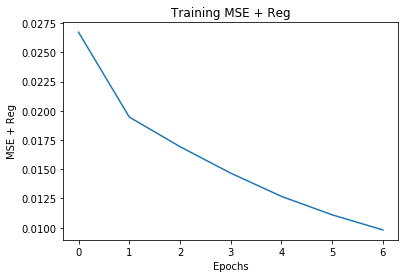

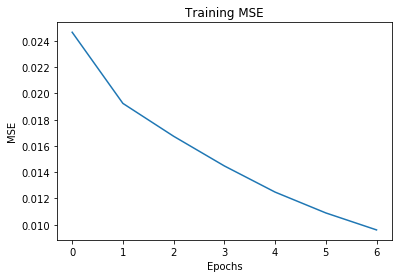

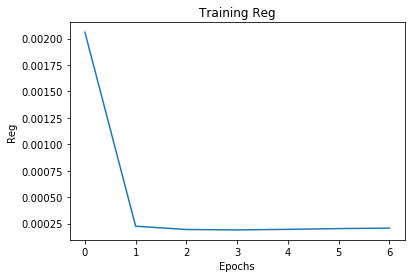

In [6]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['train_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Training MSE + Reg')
plot_floats(model['train_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Training MSE')
plot_floats(model['train_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Training Reg')

In [7]:
print('_________________________Validation Table_________________________')
for k, v in model['val_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['val_pred_loss'][k][0], model['val_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

_________________________Validation Table_________________________
Epoch: 0 | Loss: 0.02213 | Pred Loss: 0.02185 | Reg Loss: 0.00028
Epoch: 1 | Loss: 0.01928 | Pred Loss: 0.01909 | Reg Loss: 0.00019
Epoch: 2 | Loss: 0.01864 | Pred Loss: 0.01846 | Reg Loss: 0.00018
Epoch: 3 | Loss: 0.01821 | Pred Loss: 0.01802 | Reg Loss: 0.00019
Epoch: 4 | Loss: 0.01823 | Pred Loss: 0.01803 | Reg Loss: 0.00020
Epoch: 5 | Loss: 0.01845 | Pred Loss: 0.01824 | Reg Loss: 0.00021
Epoch: 6 | Loss: 0.01813 | Pred Loss: 0.01792 | Reg Loss: 0.00021


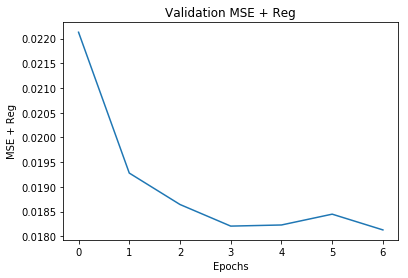

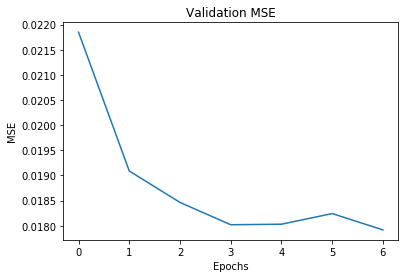

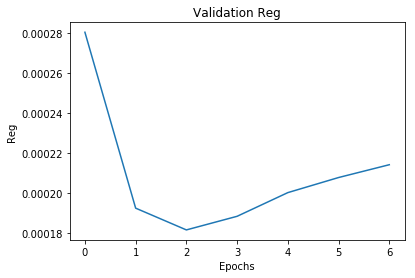

In [8]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['val_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Validation MSE + Reg')
plot_floats(model['val_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Validation MSE')
plot_floats(model['val_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Validation Reg')

In [9]:
# Evaluation on Test Set

loss, pred_loss, reg_loss = evalset.computeLoss(trainer, model['mode'])
print(str.join(" | ", ['Test Set:', 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

prec, extract = evalset.evaluatePrecision(trainer,model['mode'])
print(str.join(" | ", ['Test Set:', 'Precision: %.5f' % (prec), 'Extract: %.5f' % (extract)]))

Test Set: | Loss: 0.01445 | Pred Loss: 0.01421 | Reg Loss: 0.00023


KeyboardInterrupt: 

In [ ]:
# Random Samples
evalset.sample(trainer, model['mode'])

In [ ]:
# Random Marginals
evalset.computeMarginals(trainer, model['mode'],100)

In [ ]:
evalset.computeMAPPredLoss(trainer, model['mode'])

In [10]:
evalset.create_MAPS(trainer, model['mode'])

In [11]:
evalset.MAPS

[([('burnished',),
   ('moderate',),
   ('sheets',),
   ('residence',),
   ('toffee',),
   ('single',),
   ('notes',),
   ('eventually',),
   ('future',),
   ('leaves',),
   ('bet',),
   ('especially',),
   ('round',),
   ('expected',),
   ('displays',),
   ('state',),
   ('former',),
   ('nicely',),
   ('long',),
   ('home',),
   ('met',),
   ('accented',),
   ('amount',),
   ('trace',),
   ('small',),
   ("'ll",),
   ('getting',),
   ('well',),
   ('overdone',),
   ('persistance',),
   ('lace',),
   ('got',),
   ('shot',),
   ('years',),
   ('contains',),
   ('would',)],
  0.8333333333333334),
 ([('style',),
   ('jane',),
   ("'ve",),
   ('middle',),
   ('prime',),
   ('sound',),
   ('means',),
   ('giving',),
   ('near',),
   ('bit',),
   ('crackers',),
   ('pronounced',),
   ('see',),
   ('left',),
   ('type',),
   ('road',),
   ('quite',),
   ('came',),
   ('offerings',),
   ('overall',),
   ('lasted',),
   ('potato',),
   ('lacing',),
   ('long',),
   ('bubble',),
   ('mind',),
 